# 1. Use the 3-step search to find motion vectors (check slides for description).

[[0.16862746 0.84705883 1.         ... 0.7764706  0.8392157  0.74509805]
 [0.19215687 0.7764706  0.75686276 ... 0.8039216  0.8235294  0.74509805]
 [0.1882353  0.7607843  0.69411767 ... 0.7058824  0.83137256 0.7372549 ]
 ...
 [0.10980392 0.50980395 0.7882353  ... 0.654902   0.64705884 0.5803922 ]
 [0.11372549 0.50980395 0.7882353  ... 0.7058824  0.7137255  0.6627451 ]
 [0.10980392 0.5058824  0.7764706  ... 0.49411765 0.49019608 0.45882353]]


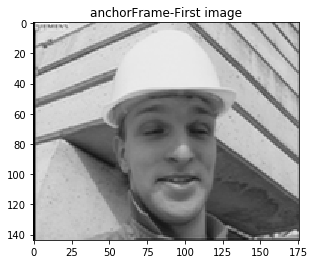

[[0.16862746 0.84705883 1.         ... 0.7647059  0.8235294  0.7490196 ]
 [0.1882353  0.7764706  0.75686276 ... 0.77254903 0.8235294  0.74509805]
 [0.19215687 0.7607843  0.6901961  ... 0.6039216  0.81960785 0.73333335]
 ...
 [0.11372549 0.50980395 0.7882353  ... 0.6509804  0.6431373  0.58431375]
 [0.10980392 0.50980395 0.78039217 ... 0.7019608  0.7137255  0.6627451 ]
 [0.10980392 0.50980395 0.78039217 ... 0.49019608 0.49411765 0.45490196]]


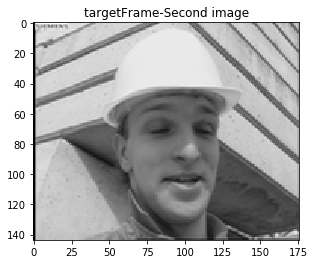

255
255


In [93]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cmath
from PIL import Image,ImageOps
anchorframe = mpimg.imread('first_frame.png')
print(anchorframe)
imgplot_1=plt.imshow(anchorframe,cmap=plt.get_cmap('gray'))
plt.title("anchorFrame-First image")
plt.show()
targetframe = mpimg.imread('second_frame.png')
print(targetframe)
imgplot_2=plt.imshow(targetframe,cmap=plt.get_cmap('gray'))
plt.title("targetFrame-Second image")
plt.show()
print(np.amax(af))
print(np.amax(tf))

In [105]:
af=np.array(anchorFrame)
tf=np.array(targetFrame)
def segmentImage(anchor, blockSize=16):
    h, w = anchor.shape
    hSegments = int(h / blockSize)
    wSegments = int(w / blockSize)
    totBlocks = int(hSegments * wSegments)
    return hSegments, wSegments

def getCenter(x, y, blockSize):
    
    return (int(x + blockSize/2), int(y + blockSize/2))

def getAnchorSearchArea(x, y, anchor, blockSize, searchArea):
    
    h, w = anchor.shape
    cx, cy = getCenter(x, y, blockSize)

    sx = max(0, cx-int(blockSize/2)-searchArea) # ensure search area is in bounds
    sy = max(0, cy-int(blockSize/2)-searchArea) # and get top left corner of search area

    # slice anchor frame within bounds to produce anchor search area
    anchorSearch = anchor[sy:min(sy+searchArea*2+blockSize, h), sx:min(sx+searchArea*2+blockSize, w)]
    
    
    return anchorSearch

def getBlockZone(p, aSearch, tBlock, blockSize):
    px, py = p # coordinates of macroblock center
    px, py = px-int(blockSize/2), py-int(blockSize/2) # get top left corner of macroblock
    px, py = max(0,px), max(0,py) # ensure macroblock is within bounds

    aBlock = aSearch[py:py+blockSize, px:px+blockSize] # retrive macroblock from anchor search area

    return aBlock

def getMAD(tBlock, aBlock):#Returns Mean Absolute Difference between current frame macroblock (tBlock) and anchor frame macroblock (aBlock)
    
    return np.sum(np.abs(np.subtract(tBlock, aBlock)))/(tBlock.shape[0]*tBlock.shape[1])

def getBestMatch(tBlock, aSearch, blockSize): #3 Step Search
    step = 4
    ah, aw = aSearch.shape
    acy, acx = int(ah/2), int(aw/2) # get center of anchor search area
    minMAD = float("inf")
    minP = None
    
    while step >= 1:
        
        p1 = (acx, acy)
        p2 = (acx+step, acy)
        p3 = (acx, acy+step)
        p4 = (acx+step, acy+step)
        p5 = (acx-step, acy)
        p6 = (acx, acy-step)
        p7 = (acx-step, acy-step)
        p8 = (acx+step, acy-step)
        p9 = (acx-step, acy+step)
        pointList = [p1,p2,p3,p4,p5,p6,p7,p8,p9] # retrieve 9 search points

        for p in range(len(pointList)):
            aBlock = getBlockZone(pointList[p],aSearch,tBlock,blockSize) # get anchor macroblock
            MAD = getMAD(tBlock,aBlock) # determine MAD
            if MAD < minMAD: # store point with minimum mAD
                minMAD = MAD
                minP = pointList[p]

        step = int(step/2)

    tx, ty = minP # center of anchor block with minimum MAD
    px, py = tx - int(blockSize/2), ty - int(blockSize/2) # get top left corner of minP
    px, py = max(0, px), max(0, py) # ensure minP is within bounds
    matchBlock = aSearch[py:py + blockSize, px:px + blockSize] # retrieve best macroblock from anchor search area
    
    return tx-p1[0],ty-p1[1]#matchBlock
    #return d1,d2
def blockSearchBody(anchor, target, blockSize, searchArea=7):
    vec=[]
    h, w = anchor.shape
    hSegments, wSegments = segmentImage(anchor, blockSize)
    bcount = 0
    for y in range(0, int(hSegments*blockSize), blockSize):
        for x in range(0, int(wSegments*blockSize), blockSize):
            bcount+=1
            targetBlock = target[y:y+blockSize, x:x+blockSize] #get current macroblock
            anchorSearchArea = getAnchorSearchArea(x, y, anchor, blockSize, searchArea) #get anchor search area
            p,q=getBestMatch(targetBlock, anchorSearchArea, blockSize) 
            vec.append([p,q]) #get best anchor macroblock
    return vec

vector = blockSearchBody(af, tf, blockSize =16, searchArea=7)
print(vector)

[[2, 2], [4, 4], [0, -4], [-4, -4], [-4, -4], [-4, -4], [4, -4], [4, -4], [4, -4], [4, -4], [4, -4], [2, -2], [-4, 4], [0, 4], [-4, 4], [-4, 4], [-4, 4], [4, 4], [2, 2], [0, -4], [0, -2], [0, -4], [1, 0], [2, 2], [0, 0], [-2, 0], [-4, 4], [-2, 2], [4, 4], [0, 2], [0, 0], [4, 0], [4, 0], [-4, 4], [0, 0], [4, 4], [4, 4], [2, 0], [-4, 4], [4, 0], [-4, 0], [-4, 0], [-4, 4], [-4, -4], [4, 0], [2, 2], [-4, 4], [-4, 4], [4, 0], [-4, 0], [-4, -4], [-4, 0], [-4, 4], [0, 4], [-2, 0], [4, 4], [4, 0], [1, 1], [-4, 0], [4, 0], [-2, 0], [4, -4], [4, 4], [-2, 2], [-4, 4], [4, 4], [4, -4], [4, -4], [0, 0], [1, 0], [-4, 4], [4, -4], [-4, 4], [4, 0], [0, 0], [-4, 4], [4, 4], [4, -4], [4, -4], [4, -4], [0, -4], [0, 1], [-4, 4], [4, 4], [0, 1], [0, 0], [0, 0], [-4, 4], [-4, 4], [4, 4], [4, 4], [4, 4], [2, -2], [-4, 4], [-4, 4], [-2, 2], [-4, 4], [-4, 4], [4, 4]]


# 2)Plot the motion vector at each macroblock. You can use the arrow function in matplotlib.

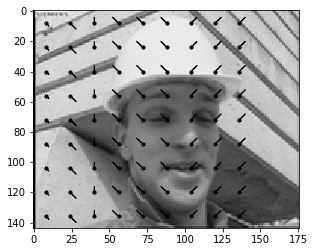

In [120]:
#Blocksize=16
for i in range(int(len(af)/16)):
    cx=i*16+8
    for j in range(int(len(af[0])/16)):
        cy=j*16+8
        plt.scatter(cx,cy,c='black',s=10)
        plt.arrow(cx,cy,vector[i][0],vector[i][1])
plt.imshow(tf,cmap='gray')
plt.show()
    

# 3)Generate the motion compensated predicted frame using the motion vectors and the first frame.

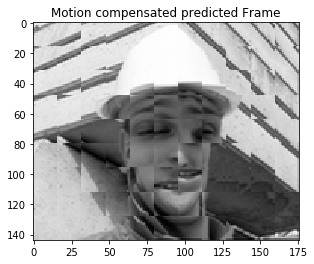

In [114]:
def getBestMatch(tBlock, aSearch, blockSize): #3 Step Search
    """
    Implemented 3 Step Search. Read about it here: https://en.wikipedia.org/wiki/Block-matching_algorithm#Three_Step_Search
    :param tBlock: macroblock from current frame
    :param aSearch: anchor search area
    :param blockSize: size of macroblock in pixels
    :return: macroblock from anchor search area with least MAD
    """
    step = 4
    ah, aw = aSearch.shape
    acy, acx = int(ah/2), int(aw/2) # get center of anchor search area

    minMAD = float("+inf")
    minP = None

    while step >= 1:
        p1 = (acx, acy)
        p2 = (acx+step, acy)
        p3 = (acx, acy+step)
        p4 = (acx+step, acy+step)
        p5 = (acx-step, acy)
        p6 = (acx, acy-step)
        p7 = (acx-step, acy-step)
        p8 = (acx+step, acy-step)
        p9 = (acx-step, acy+step)
        pointList = [p1,p2,p3,p4,p5,p6,p7,p8,p9] # retrieve 9 search points

        for p in range(len(pointList)):
            aBlock = getBlockZone(pointList[p], aSearch, tBlock, blockSize) # get anchor macroblock
            MAD = getMAD(tBlock, aBlock) # determine MAD
            if MAD < minMAD: # store point with minimum mAD
                minMAD = MAD
                minP = pointList[p]

        step = int(step/2)

    px, py = minP # center of anchor block with minimum MAD
    px, py = px - int(blockSize / 2), py - int(blockSize / 2) # get top left corner of minP
    px, py = max(0, px), max(0, py) # ensure minP is within bounds
    matchBlock = aSearch[py:py + blockSize, px:px + blockSize] # retrieve best macroblock from anchor search area

    return matchBlock



def blockSearchBody(anchor, target, blockSize, searchArea=7):
    
    h, w = anchor.shape
    hSegments, wSegments = segmentImage(anchor, blockSize)


    predicted = np.ones((h, w))*255
    bcount = 0
    for y in range(0, int(hSegments*blockSize), blockSize):
        for x in range(0, int(wSegments*blockSize), blockSize):
            bcount+=1
            targetBlock = target[y:y+blockSize, x:x+blockSize] #get current macroblock

            anchorSearchArea = getAnchorSearchArea(x, y, anchor, blockSize, searchArea) #get anchor search area

            anchorBlock = getBestMatch(targetBlock, anchorSearchArea, blockSize) #get best anchor macroblock
            predicted[y:y+blockSize, x:x+blockSize] = anchorBlock #add anchor block to predicted frame

            
    assert bcount == int(hSegments*wSegments) #check all macroblocks are accounted for

    return predicted

predictedFrame=blockSearchBody(af,tf,16,searchArea=7)
imgplot=plt.imshow(predictedFrame,cmap=plt.get_cmap('gray'))
plt.title("Motion compensated predicted Frame")
plt.show()

# 4)Compute the error between the second frame and its motion compensated predicted version and display it.

In [115]:
err=getMAD(tf,predictedFrame)
print(err)

17.99569917929293
